In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, MACCSkeys, RDKFingerprint
from rdkit.Avalon import pyAvalonTools
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit import DataStructs
from minisom import MiniSom
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from rdkit.Chem.Descriptors import ExactMolWt
from utilities import tokenizer as tkn
import pickle

from utilities.config import Config

config = Config(smiles_format=2, topn_fp_features=5, mode='threshold', max_fp_features=2048, threshold=0.3, morgan_radius=2)

np.set_printoptions(suppress=True)

# Plan A: Set the diff threshold. Solution 
# Plan B: Set the number of features to be saved. Larger features are easier to save.
# threshold = 0.28
# num_features = 5

# fptype: rdkit, MACCSkeys, Morgan, Avalon
fptype = 'rdkit'

In [2]:
# read the molecules from LA and zinc files, c

# 读取LA的smiles分子式
LA_list = []
with open(config.LA_smiles_file, 'r', encoding='utf-8') as f:
    for line in f:
        LA_list.append(line.strip())

# 读取zinc的smiles分子式
zinc_list = []
with open(config.zinc_file, 'r', encoding='utf-8') as f:
    for line in f:
        zinc_list.append(line.strip().split(',')[0])
        
zinc_sampled_list = random.sample(zinc_list, 5*len(LA_list))

### Define some functions to obtain smile molecular fingerprints
Molecular fingerprints include many types:

 * rdkit：RDKFingerprint
 * MACCSkeys: MACCSkeys
 * ...
 

In [3]:
def get_rdkitFP(smiles):
    fingerprints = []
    safe = []
    for sm_idx, sm in enumerate(smiles):
        try:
            mol = Chem.MolFromSmiles(sm)
            fingerprint = RDKFingerprint(mol)
            fingerprints.append(fingerprint)
            safe.append(sm_idx)
        except:
            print("Error: "+str(sm_idx))

    fp_TopoFingerprint = pd.DataFrame(fingerprints)
    num_of_smiles = fp_TopoFingerprint.shape[0]
    
    fp_list = []
    for fp in fp_TopoFingerprint[0]:
        arr = np.zeros((0, ), dtype=np.int8)
        ConvertToNumpyArray(fp, arr)
        fp_list.append(arr)
        
    return np.array(fp_list)

def get_MACCSkeys(smiles):
    fingerprints = []
    for idx,sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        try:
            fp = [x for x in MACCSkeys.GenMACCSKeys(mol)]
            fingerprints.append(fp)
        except:
            print("Error", idx)
            
    return np.array(fingerprints)


def get_MorganFP(smiles):
    fingerprints = []
    for idx,sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        try:
            fp = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, config.morgan_radius, config.max_fp_features)]
            fingerprints.append(fp)
        except:
            print("Error", idx)
            
    return np.array(fingerprints)

def get_AvalonFP(smiles):
    fingerprints = []
    for idx,sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        try:
            fp = [x for x in pyAvalonTools.GetAvalonFP(mol)]
            fingerprints.append(fp)
        except:
            print("Error", idx)
    
    return np.array(fingerprints)

### 定义获取分子指纹的函数, 默认为rdkit指纹

from: https://www.daylight.com/dayhtml/doc/theory/theory.finger.html

> In spite of the difference between the meaning of a fingerprint's bits and a structural key's bits, fingerprints share an important feature with structural keys: If a pattern is a substructure of a molecule, every bit that is set in the pattern's fingerprint will be set in the molecule's fingerprint. This means that, like structural keys, we can use simple boolean operations on fingerprints to screen molecules as we search a database, making a fingerprint comparison an extremely fast screen for substructure searching.

> The best way to think of the bits of a fingerprint is as "shared" among an unknown but very large number
The best way to think of the bits of a fingerprint is as "shared" among an unknown but very large number of patterns. Each pattern generates its particular set of bits; so long as at least one of those bits is unique (not shared with any other pattern present in the molecule), we can tell if the pattern is present or not. A structural key indicates with certainty that a particular pattern is present or absent. Fingerprints are not so definite: if a fingerprint indicates a pattern is missing then it certainly is, but it can only indicate a pattern's presence with some probability. Although a fingerprint doesn't indicate with 100% certainty that a particular pattern is present, it contains far more patterns total than a structural key, the net result being that a fingerprint is a far better screen than a structural key in almost all situations.

上面两段话意思就是，如果把一个分子拆分成很多种不同的patterns，那么每个pattern会通过hash，hash到一个bit，通常一个bit会对应多个patterns，所以某一位为1，说明这些patterns都可能存在，但是如果是0，那么这些patterns都不存在

In [4]:
def get_fingerprints_from_smiles(smiles, fptype='rdkit'):
    if fptype == 'rdkit':
        return get_rdkitFP(smiles)
    elif fptype == 'MACCSkeys':
        return get_MACCSkeys(smiles)
    elif fptype == 'Morgan':
        return get_MorganFP(smiles)
    elif fptype == 'Avalon':
        return get_AvalonFP(smiles)

### Define the function: Given two smiles data sets, return the top N subscripts with the largest frequency difference in the feature occurrence in the molecular fingerprint

In [5]:
def get_maxDiff_idxs(fps1, fps2, mode='topn'):
    '''
    fps1, fps2: two different fingerprints arrays from different kinds of datasets
    mode: 1. topn: mannually choose the top-n indexs， n is the number of features in fingerprints
          2. threshold: set the difference threshold, top-n is not sure
          3. all: use all features
    
    return: the top-n indexes (np.array) with the largest feature frequency gap in molecular fingerprints
    '''
    # 对分子指纹的每一位（个）特征进行数量统计,除以样本数量以正则化

    # 计算每一位的个数
    sum_1 = np.sum(fps1, axis=0)
    sum_2 = np.sum(fps2, axis=0)
    # 计算差值，
    diff = sum_1/fps1.shape[0] - sum_2/fps2.shape[0]
    
    if config.mode == 'topn':
        # 利用topn_fp_features计算下标
        idxs = np.argsort(np.abs(diff))[::-1][:config.topn_fp_features]
    elif config.mode == 'threshold':
        # 利用threshold计算下标
        idxs = np.where(np.abs(diff) >= config.threshold)[0]
    else:
        idxs = list(range(len(diff)))
    
    print("The top %d indexes with the largest feature frequency gap:" %len(idxs))
    print("indexs: ", idxs)
    print("frequency differences: ", diff[idxs])
    return idxs

### 计算indexs

In [6]:
LA_fps = get_fingerprints_from_smiles(LA_list, fptype)
zinc_fps = get_fingerprints_from_smiles(zinc_sampled_list, fptype)

idxs = get_maxDiff_idxs(LA_fps, zinc_fps, mode=config.mode)

RDKit WARNING: [17:12:51] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:12:51] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:12:51] WARNING: not removing hydrogen atom without neighbors


The top 37 indexes with the largest feature frequency gap:
indexs:  [   5  104  122  139  202  302  357  361  382  413  440  472  501  552
  556  684  771  775  786  826  862  894  915  936 1144 1225 1270 1399
 1653 1694 1718 1725 1824 1920 1926 2025 2037]
frequency differences:  [-0.33160173 -0.33463203 -0.31904762 -0.30909091  0.31818182  0.37705628
 -0.33116883  0.32424242 -0.32034632 -0.33636364  0.36450216 -0.32510823
  0.3012987   0.32987013  0.31645022 -0.31688312  0.33636364  0.33290043
  0.33549784 -0.34069264  0.30909091  0.33766234 -0.32380952  0.44632035
 -0.37575758  0.34199134  0.37186147  0.31688312  0.36363636 -0.33116883
  0.35497835  0.35887446  0.33073593  0.31471861 -0.32337662 -0.30952381
  0.35064935]


### 打好标签，重新抽取zinc数据（1:1），并进行SOM训练

In [7]:
# 重新抽取LA和zinc数据集，1:1
LA_list_labeled = [sm + ',LA' for sm in LA_list]
zinc_list_labeled = [sm +',ZINC' for sm in zinc_list]


zinc_sampled_list = random.sample(zinc_list_labeled, len(LA_list))
smile_list = LA_list_labeled + zinc_sampled_list
random.shuffle(smile_list)

# 将抽取结果保存至文件
with open(config.SOM_smiles_file, 'w', encoding='utf-8') as f:
    for sm in smile_list:
        f.write(sm+'\n')

In [8]:
# 读取训练数据，生成二元label
train_smiles_list = []
label_list = []
with open(config.SOM_smiles_file, 'r', encoding='utf-8') as f:
    for line in f:
        smile, label = line.strip().split(',')
        train_smiles_list.append(smile)
        label_list.append(0 if label != 'LA' else 1)
        
print("There are "+ str(len(train_smiles_list)) +" smile molecules in total!")
print("The rectangle size should be at least: " + str(math.ceil(np.sqrt(5 * np.sqrt(len(train_smiles_list))))))


fingerprints = get_fingerprints_from_smiles(train_smiles_list, fptype).astype(np.float32)
fps = fingerprints[:, idxs]
labels = np.array(label_list)

np.save(config.SOM_fps, fps)
np.save(config.SOM_labels, labels)

There are 924 smile molecules in total!
The rectangle size should be at least: 13


RDKit WARNING: [17:12:58] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:12:58] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:12:58] WARNING: not removing hydrogen atom without neighbors


In [9]:
size = 20
som = MiniSom(size, size, fps.shape[1], sigma=3, learning_rate=0.5, neighborhood_function='triangle', activation_distance='euclidean')
# som.pca_weights_init(fps)
som.random_weights_init(fps)
som.train(fps, 20000, random_order=True, verbose=True)
winmap = som.labels_map(fps,labels)

 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 0.8566615218275091


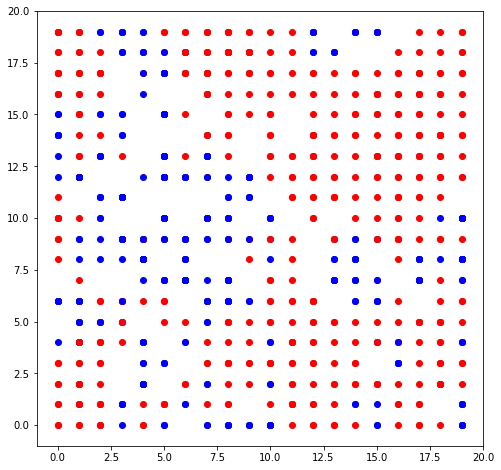

In [10]:
plt.figure(figsize=(8, 8))
wmap = {}
im = 0

for x, t in zip(fps, labels):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt.scatter(w[0],  w[1], color='red' if t==0 else 'blue')
    im = im + 1
plt.axis([-1, som.get_weights().shape[0], -1,  som.get_weights().shape[1]])
plt.show()

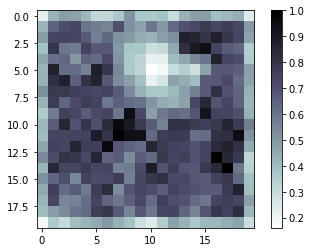

In [11]:
heatmap = som.distance_map()
plt.imshow(heatmap, cmap='bone_r')
plt.colorbar()

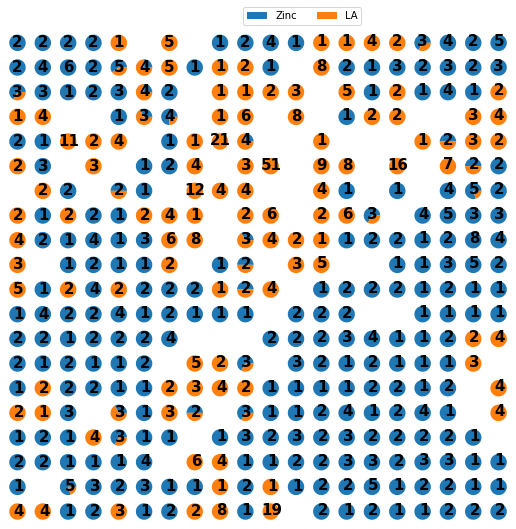

In [12]:
label_name_map_number = {"LA":1,"Zinc":0}
class_names = ["Zinc", "LA"]

from matplotlib.gridspec import GridSpec
plt.figure(figsize=(9, 9))
the_grid = GridSpec(size, size)
for position in winmap.keys():
    label_fracs = [winmap[position][label] for label in [0,1]]
    plt.subplot(the_grid[position[0], position[1]], aspect=1)
    patches, texts = plt.pie(label_fracs)
    plt.text(position[0]/100, position[1]/100,  str(len(list(winmap[position].elements()))),
              color='black', fontdict={'weight': 'bold',  'size': 15},
              va='center',ha='center')
plt.legend(patches, class_names, loc='center right', bbox_to_anchor=(-1,9), ncol=3)
plt.show()


### 保存SOM模型

In [13]:
with open(config.SOM_model, 'wb') as outfile:
    pickle.dump(som, outfile)

### 设置基于SOM模型的打分函数
>  输入：1. smiles分子 2. radius(得分点半径) 3. 训练好的som模型   
  输出：reward  
  算法：给定一个smiles分子，通过som计算得出优胜权重节点，再根据优胜权重节点，以radius为半径画圆，圆以内的为有效的节点，其中有效的为正1，无效的为负1。计算这个圆内的分数，然后判定为reward分数。


In [14]:
def points_in_radius(center, size, radius):
    x_c, y_c = center
    side_arr = np.array(list(range(size)))
    x_grid, y_grid = np.meshgrid(side_arr, side_arr)
    disk = ((x_grid - x_c)**2 + (y_grid - y_c)**2) <= radius**2
    return list(zip(x_grid[disk], y_grid[disk]))


def som_reward(smiles, som, winmap, config, index, radius=1, ftype='rdkit'):
    # 0. get the fingerprint of smiles
    reward = None
    if not smiles or not som:
        return reward
    
    fp = get_fingerprints_from_smiles([smiles], ftype)[:, index]
    # 1. get the winner point using fingerprint and som
    winner_point = som.winner(fp)
    
    # 2. find the points in the circle with winner as the center and radius
    points = points_in_radius(winner_point, som._neigx.shape[0], radius)
    # 3. calculate the rewards by all the points in that circle
    reward = 0
#     print(winner_point, points)
    for p in points:
        ct = winmap[p]
        if len(ct) > 0:
            reward = reward - ct[0] + ct[1]
            if p == winner_point:
                reward = reward - 0.5 * (ct[0] - ct[1])
    
    return reward

### 读取SOM模型

In [15]:
with open(config.SOM_model, 'rb') as infile:
    som = pickle.load(infile)

# read the fingerprints and labels that are used in training SOM model
fps = np.load(config.SOM_fps)
labels = np.load(config.SOM_labels)
# calculate the winner map on the original dataset
winmap = som.labels_map(fps,labels)

### 测试单个smiles分子

In [16]:
smiles = 'CCCC1CN(c2nc(C)cc(C)n2)CC1NC(=O)C1(COC)CC1'
som_reward(smiles, som, winmap, config, index=idxs, radius=1, ftype='rdkit')

-7.5

### 测试多个smiles分子

RDKit WARNING: [17:13:56] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:13:56] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:13:56] WARNING: not removing hydrogen atom without neighbors


(array([  9.,  68., 168.,  96.,  43.,  24.,   0.,   0.,   3.,  51.]),
 array([-13.5,  -4.2,   5.1,  14.4,  23.7,  33. ,  42.3,  51.6,  60.9,
         70.2,  79.5]),
 <BarContainer object of 10 artists>)

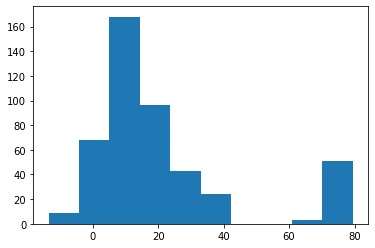

In [17]:
# read all LA molecules in smiles foramt
LA_smiles = []
with open(config.LA_smiles_file, 'r', encoding='utf-8') as f:
    for line in f:
        LA_smiles.append(line.strip())
        
LA_rewards = []
for sm in LA_smiles:
    LA_rewards.append(som_reward(sm, som, winmap, config, index=idxs, radius=1, ftype='rdkit'))
    
    
plt.hist(LA_rewards)

(array([ 482., 2831., 1083.,  197.,   19.,    7.,    0.,    0.,    0.,
           1.]),
 array([-26.  , -15.45,  -4.9 ,   5.65,  16.2 ,  26.75,  37.3 ,  47.85,
         58.4 ,  68.95,  79.5 ]),
 <BarContainer object of 10 artists>)

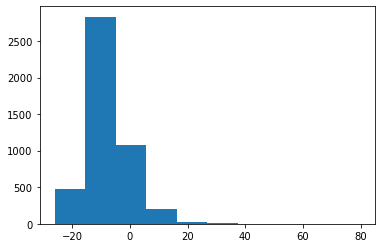

In [18]:
# read all zinc molecules in smiles format
zinc_smiles = []
with open(config.zinc_file, 'r', encoding='utf-8') as f:
    for line in f:
        zinc_smiles.append(line.strip().split(',')[0])

zinc_smiles.remove('SMILES')

zinc_sampled_smiles = random.sample(zinc_smiles, 10*len(LA_smiles))

zinc_rewards = []
for sm in zinc_sampled_smiles:
    zinc_rewards.append(som_reward(sm, som, winmap, config, index=idxs, radius=1, ftype='rdkit'))

plt.hist(zinc_rewards)

In [19]:
wrong = [r for r in zinc_rewards if r > 0 ]
print(len(wrong), len(zinc_rewards), len(wrong)/len(zinc_rewards))

550 4620 0.11904761904761904
